In [101]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from patsy import dmatrix, dmatrices
import sklearn.metrics as metrics
from distfit import distfit
import scipy.stats as stats
import itertools
from sklearn.feature_selection import SelectKBest, f_classif
import statsmodels.api as sm
from sklearn.model_selection import KFold, train_test_split
from tqdm.auto import tqdm
from statsmodels.othermod.betareg import BetaModel
from sklearn.ensemble import RandomForestRegressor
import pickle

Our approach to building a predictive model was to look at college level attributes from table 10 and use those to predict the economic mobility factor tracking movement from the bottom quintile to the top quintile. Using this model, we would then be able to see how making slight changes to any of these college level factors (things like faculty salary or sticker price) might impact the likelihood of having students make this economic jump.

In [2]:
income_college = pd.read_csv('mrc_table2.csv')
college_characteristics = pd.read_csv('mrc_table10.csv')
cols_to_use = list(college_characteristics.columns.difference(income_college.columns)) + ['super_opeid']
df= income_college.merge(college_characteristics[cols_to_use], on='super_opeid')
df["region"] = df["region"].astype(int)

In [3]:
BUFFER = 0.000001

After loading our data, we checked what columns had the greatest density of NaN values, since these would likely not be useful for us. Unfortunately, this did include some interesting columns covering things like SAT score and rejection rate.

In [4]:
for col in college_characteristics.columns:
    print(f"{col:40} {df[col].isna().mean():8.4%}")

super_opeid                               0.0000%
name                                      0.0000%
region                                    0.0000%
state                                     0.0000%
fips                                      0.0000%
cz                                        0.0000%
czname                                    0.0000%
cfips                                     0.0000%
county                                    0.4093%
zip                                       0.0000%
tier                                      0.0000%
tier_name                                 0.0000%
type                                      0.0000%
iclevel                                   0.0000%
public                                    0.0000%
barrons                                   0.0000%
exp_instr_pc_2000                         1.6826%
exp_instr_pc_2013                         0.2729%
multi                                     0.0000%
hbcu                                      0.0000%


After this we started selecting our pool of features and doing feature engineering. This included going through one by one to identify which variables should be categorical, which should be linear, and which may need to have a log applied. We also did feature engineering to multiply and divide variables that we thought might be more descriptive together than in isolation.

In [5]:
formula = """mr_kq5_pq1 ~ C(region) + C(state) + C(tier_name) + C(iclevel) + 
             barrons + np.log10(exp_instr_pc_2013) + hbcu + flagship + np.log10(ipeds_enrollment_2013) +
             sticker_price_2013 + grad_rate_150_p_2013 + 
             avgfacsal_2013 + 
             scorecard_netprice_2013 + scorecard_median_earnings_2011 +
             np.log10(exp_instr_2012) + asian_or_pacific_share_fall_2000 +
             black_share_fall_2000 + hisp_share_fall_2000 + alien_share_fall_2000 + pct_arthuman_2000 + 
             pct_business_2000 + pct_health_2000 + pct_multidisci_2000 + pct_publicsocial_2000 + 
             pct_stem_2000 + pct_socialscience_2000 + pct_tradepersonal_2000 - 1"""
formed = dmatrices(formula, df)

In [6]:
X = pd.DataFrame(formed[1])
X.columns = formed[1].design_info.column_name_indexes
data = X
data['output'] = formed[0]
# Drop any constant cols
cols = [col for col in data.columns if data[col].nunique() != 1]
data = data[cols]

In [7]:
def modify_features(data):
    """Given an input dataframe, this does some feature engineering to create features of interest.
    Mostly, these are feature interactions."""

    data = data.copy()

    # Keenly interested in how the majors and racial breakdowwns interact w/ each other moreso than raw numbers
    # Does a school with heavy stem, but light business do better than stem alone, etc.
    majors_and_shares = data.columns[
        (data.columns.str.contains("pct_") | data.columns.str.contains("share_")) & 
        (~data.columns.str.contains("_X_")) & (~data.columns.str.contains("_DIV_"))
    ]
    data[majors_and_shares] = data[majors_and_shares].fillna(0)
    out = {}
    for i, c1 in enumerate(majors_and_shares):
        for j, c2 in enumerate(majors_and_shares):
            if j > i:
                out[f"{c1}_X_{c2}"] = data[c1] * data[c2]
                out[f"{c1}_DIV_{c2}"] = (data[c1] / (data[c1] + data[c2])).fillna(0)
    out = pd.DataFrame(out)
    to_drop = [col for col in out.columns if col in data.columns]        
    data = data.drop(to_drop, axis=1).join(out, how='outer')

    # The barrons score we modify to make it more linear, in case that is useful to the model
    if "barrons" in data.columns:
        data['mod_barrons'] = data.barrons.apply(lambda x: x if x != 999 else 10)

    # Finally we also generate a ratio of faculty salary to sticker price
    data['avgfacsal_2013_DIV_sticker_price_2013'] = data.avgfacsal_2013 / data.sticker_price_2013

    return data

data = modify_features(data)

Finally, we took a look at the underlying distribution of the mobility scores. This is a probability, and so it is clamped 0 to 1. We took several different approaches to treating this throughout our exploration, including treating it as a categorical variable by random sampling, but ultimately treating it as a continuous variable proved a better result. We first found the distribution using the distfit package, which checks all of scipy's applicable distributions for fit. The genextreme distribution was the best, which is somewhat plausible. This is an extreme scenario, and so it is possible that we are tracking the extreme occurences of an underlying economic mobility distribution. Unfortunately, there is no easy-access genextreme regression in python, and so we looked at the next two best fits: lognormal and beta.

In [8]:
dif = distfit()
dif.fit_transform(data.output + 1)

dif.summary

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 3782.67] [loc=1.018 scale=0.012]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 8983.57] [loc=1.000 scale=0.018]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 8983.57] [loc=-2097151.000 scale=2097152.000]
[distfit] >INFO> [dweibull  ] [0.09 sec] [RSS: 1572.84] [loc=1.015 scale=0.008]
[distfit] >INFO> [t         ] [0.20 sec] [RSS: 1223.92] [loc=1.015 scale=0.007]
[distfit] >INFO> [genextreme] [0.10 sec] [RSS: 205.319] [loc=1.013 scale=0.007]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 21169.5] [loc=1.000 scale=0.081]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 406.916] [loc=0.996 scale=0.019]
[distfit] >INFO> [beta      ] [0.12 sec] [RSS: 860.755] [loc=0.999 scale=33210027265.487]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 16643.5] [loc=1.000 scale=0.164]
[distfit] >INFO> [loggamma  ] [0.05 sec] [RSS: 3922.27] [loc=-1.458 scale=0.365]
[distfit] >INFO> Compute confidence intervals [p

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,genextreme,205.319271,1.012587,0.007076,"(-0.13813134932419727,)","(-0.13813134932419727, 1.0125873154804692, 0.0...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,lognorm,406.916069,0.996231,0.019232,"(0.47151250127276695,)","(0.47151250127276695, 0.9962307379168127, 0.01...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,beta,860.755073,0.999029,33210027265.486542,"(3.2902562434725855, 5822117097727.949)","(3.2902562434725855, 5822117097727.949, 0.9990...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#377eb8
3,t,1223.924849,1.015202,0.006675,"(2.749905501387675,)","(2.749905501387675, 1.0152019484626187, 0.0066...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#4daf4a
4,dweibull,1572.841372,1.014953,0.007667,"(0.9753636421579346,)","(0.9753636421579346, 1.0149529379999997, 0.007...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#984ea3
5,norm,3782.672532,1.017833,0.011997,(),"(1.0178331233201963, 0.01199724186048446)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#ff7f00
6,loggamma,3922.274733,-1.45793,0.365114,"(880.933565388663,)","(880.933565388663, -1.457929913647365, 0.36511...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#ffff33
7,expon,8983.567279,1.0,0.017833,(),"(1.0, 0.017833123320196265)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#a65628
8,pareto,8983.567361,-2097151.0,2097152.0,"(117598694.0605483,)","(117598694.0605483, -2097151.0, 2097151.999999...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#f781bf
9,uniform,16643.455052,1.0,0.16358,(),"(1.0, 0.16357975000000002)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


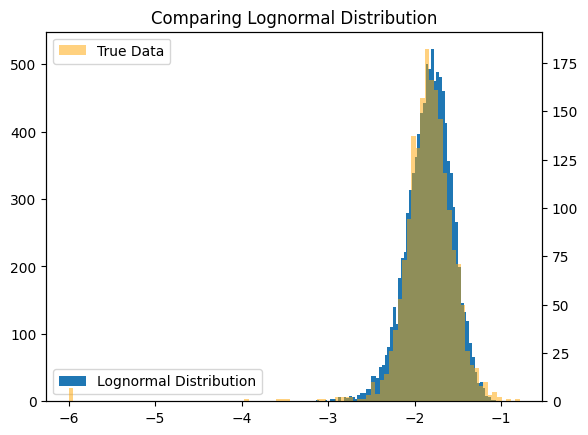

In [9]:
r = stats.lognorm(*stats.lognorm.fit(data.output))
plt.hist(np.log10(r.rvs(10_000)), bins=100, label="Lognormal Distribution")
ax = plt.gca()
ax2 = ax.twinx()
ax2.hist(np.log10(data.output + BUFFER), bins=100, color='orange', alpha=0.5, label="True Data")
ax2.legend()
ax.legend(loc="lower left")
plt.title("Comparing Lognormal Distribution")
pass

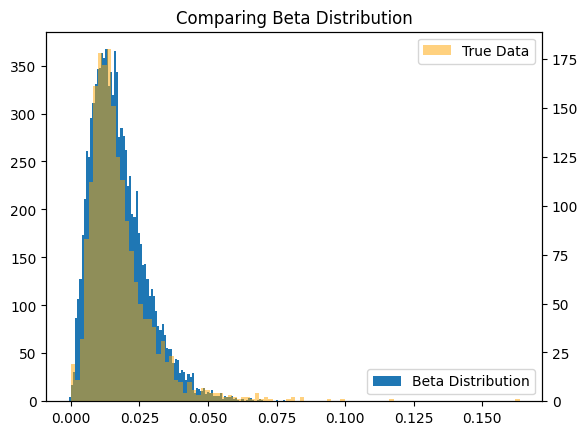

In [10]:
r = stats.beta(*stats.beta.fit(data.output))
plt.hist(r.rvs(10_000), bins=100, label="Beta Distribution")
ax = plt.gca()
ax2 = ax.twinx()
ax2.hist(data.output, bins=100, color='orange', alpha=0.5, label="True Data")
ax2.legend()
ax.legend(loc="lower right")
plt.title("Comparing Beta Distribution")
pass

Given this information, we tested out three models:
1. Lognormal Regression (which is just linear regression after applying a log to the dependent variable)
2. Beta Regression
3. Random Forest Regression

For each of these we used the univariate `SelectKBest` to identify the features to use, and ran each model in a custom built `GridSearchCV` equivalent mode searching for the best number of features to use. Each run of the model used 5 fold validation to ensure we were not overfitting. We then recorded the MSE of every model at every k and compared all three to find the best model and the best k.

In [11]:
final_results = {}

N_FOLDS = 5
RANDOM_STATE = 94378548

k_values = [int(np.floor(i)) for i in np.linspace(10, data.shape[1], 20)]

y = (data.output + BUFFER)
y = y.to_numpy()

  0%|          | 0/20 [00:00<?, ?it/s]

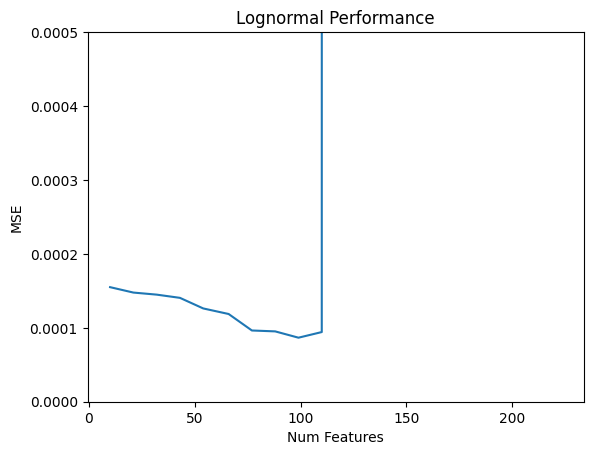

In [13]:
final_ks = []
final_scores = []

for k in tqdm(k_values):
    X = SelectKBest(k=k).fit_transform(data.drop("output", axis=1), y)
    X = X.T
    X = np.vstack((np.ones((1,X.shape[1])), X)).T
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    scores = []
    
    # Perform k-Fold Cross-Validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
    
        model = sm.OLS(np.log10(y_train), X_train)
        result = model.fit()
        pred = 10**result.predict(X_test)
        pred = pred.clip(0, 100_000_000) # Clip at a 100M arbitrarily
        score = metrics.mean_squared_error(y_test, pred)
        scores.append(score)
    final_ks.append(k)
    final_scores.append(np.mean(scores))

plt.plot(final_ks, final_scores)
plt.ylim([0, 0.0005])
plt.xlabel("Num Features")
plt.ylabel("MSE")
plt.title("Lognormal Performance")
final_results["lognorm"] = [final_ks, final_scores]

  0%|          | 0/20 [00:00<?, ?it/s]

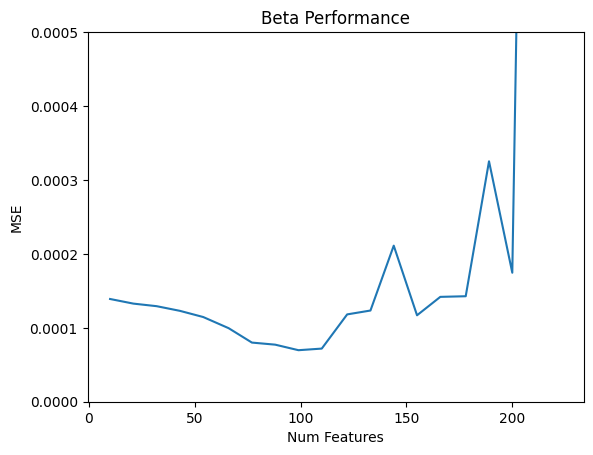

In [146]:
final_ks = []
final_scores = []

for k in tqdm(k_values):
    X = SelectKBest(k=k).fit_transform(data.drop("output", axis=1), y)
    X = X.T
    X = np.vstack((np.ones((1,X.shape[1])), X)).T
    
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    scores = []
    
    # Perform k-Fold Cross-Validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
            
        model = BetaModel(y_train, X_train)
        result = model.fit()
        pred = result.predict(X_test).clip(0,1)
        score = metrics.mean_squared_error(y_test, pred)
        scores.append(score)
    final_ks.append(k)
    final_scores.append(np.mean(scores))

plt.plot(final_ks, final_scores)
plt.ylim([0, 0.0005])
plt.xlabel("Num Features")
plt.ylabel("MSE")
plt.title("Beta Performance")
final_results["beta"] = [final_ks, final_scores]

  0%|          | 0/20 [00:00<?, ?it/s]

[distfit] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


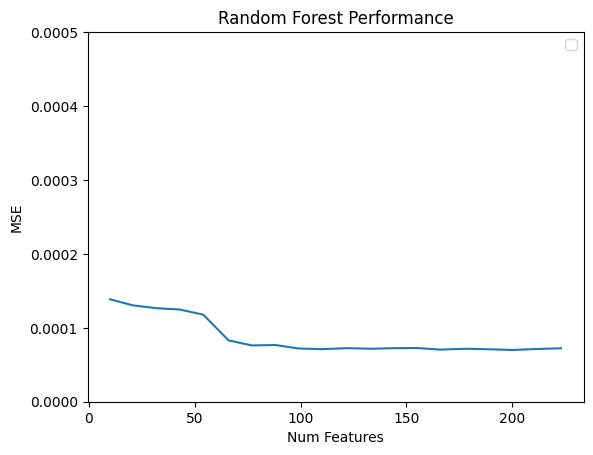

In [16]:
final_ks = []
final_scores = []
for k in tqdm(k_values):
    X = SelectKBest(k=k).fit_transform(data.drop("output", axis=1), y)
    X = X.T
    X = np.vstack((np.ones((1,X.shape[1])), X)).T
    
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    scores = []
    
    # Perform k-Fold Cross-Validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
          
        model = RandomForestRegressor(n_estimators=100, max_depth=10)
        result = model.fit(X_train, y_train)
        pred = result.predict(X_test)
        score = metrics.mean_squared_error(y_test, pred)
        scores.append(score)
    final_ks.append(k)
    final_scores.append(np.mean(scores))

plt.plot(final_ks, final_scores)
final_results[f"rf"] = [final_ks, final_scores]
plt.ylim([0, 0.0005])
plt.xlabel("Num Features")
plt.ylabel("MSE")
plt.title("Random Forest Performance")

In [24]:
best_k = final_results["rf"][0][np.argmin(final_results["rf"][1])]

n_estimators = [50, 100, 200]
max_depth = [None, 5, 10]

hyperparams = {}

X = SelectKBest(k=best_k).fit_transform(data.drop("output", axis=1), y)
X = X.T
X = np.vstack((np.ones((1,X.shape[1])), X)).T

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

combined = list(itertools.product(n_estimators, max_depth))

for ne, md in tqdm(combined):
    scores = []
    # Perform k-Fold Cross-Validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
          
        model = RandomForestRegressor(n_estimators=ne, max_depth=md)
        result = model.fit(X_train, y_train)
        pred = result.predict(X_test)
        score = metrics.mean_squared_error(y_test, pred)
        scores.append(score)
    hyperparams[(ne, md)] = np.mean(scores)

  0%|          | 0/9 [00:00<?, ?it/s]

In [38]:
min_val = np.inf
min_key = None
for key, val in hyperparams.items():
    if val < min_val:
        min_val = val
        min_key = key
print(f"Best MSE: {min_val}")

best_ne = min_key[0]
best_md = min_key[1]

print(f"Best num estimators: {min_key[0]}")
print(f"Best max depth: {min_key[1]}")

Best MSE: 6.917702525480299e-05
Best num estimators: 200
Best max depth: None


  0%|          | 0/20 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Random Forest Performance')

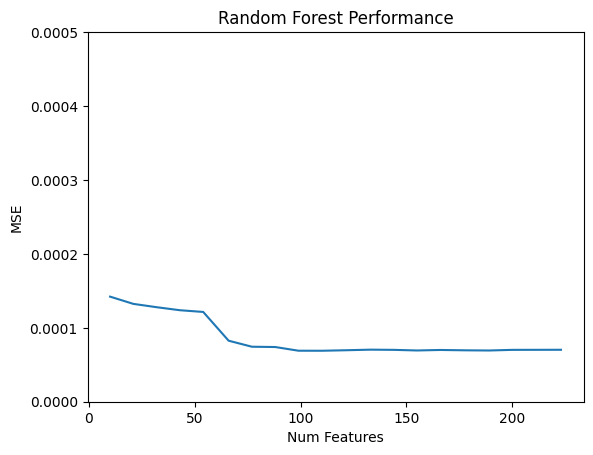

In [39]:
final_ks = []
final_scores = []
for k in tqdm(k_values):
    X = SelectKBest(k=k).fit_transform(data.drop("output", axis=1), y)
    X = X.T
    X = np.vstack((np.ones((1,X.shape[1])), X)).T
    
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    
    scores = []
    
    # Perform k-Fold Cross-Validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
          
        model = RandomForestRegressor(n_estimators=best_ne, max_depth=best_md)
        result = model.fit(X_train, y_train)
        pred = result.predict(X_test)
        score = metrics.mean_squared_error(y_test, pred)
        scores.append(score)
    final_ks.append(k)
    final_scores.append(np.mean(scores))

plt.plot(final_ks, final_scores)
final_results[f"rf_optimized"] = [final_ks, final_scores]
plt.ylim([0, 0.0005])
plt.xlabel("Num Features")
plt.ylabel("MSE")
plt.title("Random Forest Performance")

In [40]:
with open("scores.pkl", "wb") as f:
    pickle.dump(final_results, f)

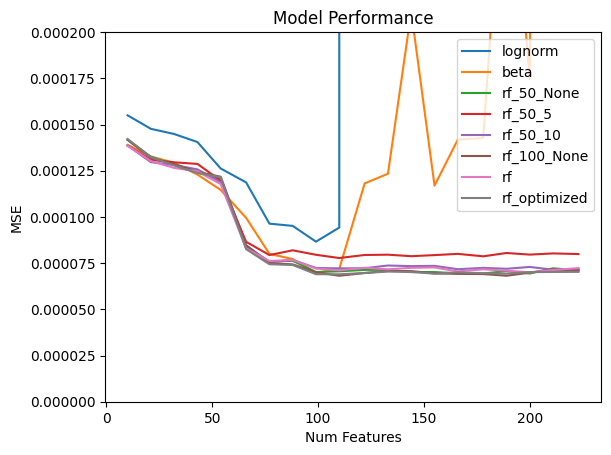

In [41]:
for key, (ks, scores) in final_results.items():
    plt.plot(ks, scores, label=key)
plt.ylim([0, 0.0002])
plt.xlabel("Num Features")
plt.ylabel("MSE")
plt.title("Model Performance")
plt.legend()

In [98]:
print(f"{'model':15} | {'k':4} | mse")
print("----------------+------+---------")
for key, val in final_results.items():
    print(f"{key:15} | {val[0][np.argmin(val[1])]:4.0f} | {np.min(val[1]):.6f}")

model           | k    | mse
----------------+------+---------
lognorm         |   99 | 0.000087
beta            |   99 | 0.000070
rf_50_None      |  200 | 0.000069
rf_50_5         |  110 | 0.000078
rf_50_10        |  211 | 0.000071
rf_100_None     |  110 | 0.000068
rf              |  200 | 0.000070
rf_optimized    |  110 | 0.000069


## Final Model Selection

Based on this analysis, the random forest model slighly outperformed the rest, but we ended up choosing the beta model since it was very comparable, but slightly more explainable.

As a result, we went with the Beta model with 100 features.

In [66]:
k = 100
skb = SelectKBest(k=k)

X = skb.fit_transform(data.drop("output", axis=1), y)
X = X.T
X = np.vstack((np.ones((1,X.shape[1])), X)).T
names = skb.get_feature_names_out()
names

array(['C(region)[3]', 'C(state)[T.AL]', 'C(state)[T.AR]',
       'C(state)[T.AZ]', 'C(state)[T.CA]', 'C(state)[T.CT]',
       'C(state)[T.DC]', 'C(state)[T.DE]', 'C(state)[T.FL]',
       'C(state)[T.GA]', 'C(state)[T.HI]', 'C(state)[T.IA]',
       'C(state)[T.ID]', 'C(state)[T.IL]', 'C(state)[T.IN]',
       'C(state)[T.KY]', 'C(state)[T.LA]', 'C(state)[T.MA]',
       'C(state)[T.MD]', 'C(state)[T.ME]', 'C(state)[T.MI]',
       'C(state)[T.MO]', 'C(state)[T.MS]', 'C(state)[T.MT]',
       'C(state)[T.NC]', 'C(state)[T.ND]', 'C(state)[T.NE]',
       'C(state)[T.NH]', 'C(state)[T.NJ]', 'C(state)[T.NM]',
       'C(state)[T.NV]', 'C(state)[T.OH]', 'C(state)[T.OK]',
       'C(state)[T.OR]', 'C(state)[T.RI]', 'C(state)[T.SC]',
       'C(state)[T.SD]', 'C(state)[T.TN]', 'C(state)[T.TX]',
       'C(state)[T.VA]', 'C(state)[T.VT]', 'C(state)[T.WA]',
       'C(state)[T.WI]', 'C(state)[T.WV]', 'C(state)[T.WY]',
       'C(tier_name)[T.Highly selective private]',
       'C(tier_name)[T.Highly select

In [67]:
key_names = []
for name in names:
    splits = ("_X_", "_DIV_")
    if name.startswith("C("):
        key_names.append(name.split(")[")[0].strip("C("))
    elif splits[0] in name or splits[1] in name:
        for s in splits:
            if s in name:
                for subname in name.split(s):
                    key_names.append(subname)
    elif "np.log10" in name:
        key_names.append(name.replace("np.log10(","").replace(")",""))
    else:
        key_names.append(name)
key_names = set(key_names)
key_names

{'alien_share_fall_2000',
 'asian_or_pacific_share_fall_2000',
 'avgfacsal_2013',
 'black_share_fall_2000',
 'exp_instr_2012',
 'flagship',
 'hbcu',
 'hisp_share_fall_2000',
 'pct_arthuman_2000',
 'pct_business_2000',
 'pct_health_2000',
 'pct_multidisci_2000',
 'pct_publicsocial_2000',
 'pct_socialscience_2000',
 'pct_stem_2000',
 'pct_tradepersonal_2000',
 'region',
 'scorecard_median_earnings_2011',
 'state',
 'sticker_price_2013',
 'tier_name'}

In [111]:
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.2, random_state=RANDOM_STATE)

In [117]:
final_model = BetaModel(y_train, X_train).fit()

In [118]:
pred = final_model.predict(X_test)

In [122]:
mse = metrics.mean_squared_error(y_test, pred)
print(f"Final MSE: {mse:.8f}")

Final MSE: 0.00007587


Text(0.5, 1.0, 'Predicted vs Actual Results')

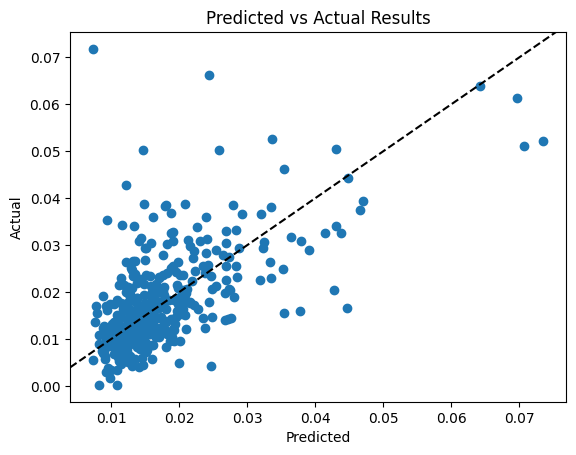

In [144]:
plt.scatter(pred, y_test)
xlim = plt.xlim()
ylim = plt.ylim()
plt.plot([0,1],[0,1],color='black', label='Ideal Mapping', linestyle='--')
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted vs Actual Results")

Text(0.5, 1.0, 'Predicted vs Actual Results')

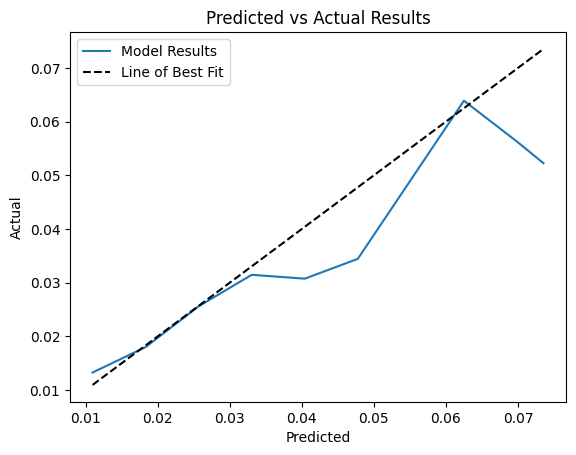

In [145]:
bins = np.linspace(np.min(pred), np.max(pred), 10)
bin_map = np.digitize(pred, bins)
t = pd.DataFrame()
t['predicted'] = pred
t['actual'] = y_test
t['bin_map'] = bin_map
t['bin'] = t.bin_map.apply(lambda x: (bins[x] + bins[x-1])/2 if x < len(bins) else bins[x-1])
t = t.groupby('bin')['actual'].mean()
plt.plot(t.index, t, label='Model Results')
plt.plot(t.index, t.index, label='Line of Best Fit', color='black', linestyle='--')
plt.legend()
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Predicted vs Actual Results")